In [27]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import glob
import cv2
import itertools
from sklearn.metrics import confusion_matrix
from keras import optimizers, losses, activations, models
from keras import applications
from keras.applications.inception_v3 import preprocess_input

In [1]:
src1 = '/home/furkan/Documents/Fire-vs-NoFire/Training/Fire'
trg1 = '/home/furkan/Documents/SDataset/Training/Fire'

src2 = '/home/furkan/Documents/Fire-vs-NoFire/Training/No_Fire'
trg2 = '/home/furkan/Documents/SDataset/Training/No_Fire'

In [26]:
print(len(os.listdir(src1)))
print(len(os.listdir(src2)))

print(len(os.listdir(trg1)))
print(len(os.listdir(trg2)))

25018
14357
11315
6500


In [4]:
train_path = '/home/furkan/Documents/SDataset/Training/'
test_path = '/home/furkan/Documents/Fire-vs-NoFire/Test/'

In [5]:

train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input,
                               validation_split=0.2)
train_gen = train_idg.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size = 16,
    subset='training')

validation_generator = train_idg.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=16,
    subset='validation')

Found 14252 images belonging to 2 classes.
Found 3563 images belonging to 2 classes.


In [6]:
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(256, 256,3))

In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
base_model.trainable = False

In [9]:
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(2, activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
file_path="/home/furkan/Documents/weightsi3.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="accuracy", mode="max", patience=15)

callbacks_list = [checkpoint, early] #early

history = model.fit_generator(train_gen, 
                              epochs=10,
                              validation_data=validation_generator,
                              shuffle=True, 
                              verbose=True,
                              callbacks=callbacks_list)

/home/furkan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
891/891 [==============================] - 795s 889ms/step - loss: 0.4511 - accuracy: 0.7891 - val_loss: 0.1170 - val_accuracy: 0.9562

Epoch 00001: accuracy improved from -inf to 0.88493, saving model to /home/furkan/Documents/weightsi3.best.hdf5
Epoch 2/10
891/891 [==============================] - 779s 874ms/step - loss: 0.1794 - accuracy: 0.9393 - val_loss: 0.1201 - val_accuracy: 0.9498

Epoch 00002: accuracy improved from 0.88493 to 0.94443, saving model to /home/furkan/Documents/weightsi3.best.hdf5
Epoch 3/10
891/891 [==============================] - 785s 881ms/step - loss: 0.1535 - accuracy: 0.9485 - val_loss: 0.0984 - val_accuracy: 0.9596

Epoch 00003: accuracy improved from 0.94443 to 0.95292, saving model to /home/furkan/Documents/weightsi3.best.hdf5
Epoch 4/10
891/891 [==============================] - 796s 894ms/step - loss: 0.1305 - accuracy: 0.9540 - val_loss: 0.0932 - val_accuracy: 0.9621

Epoch 00004: accuracy improved from 0.95292 to 0.95474, saving model t

In [11]:
model.save("/home/furkan/Documents/ReducedData10Ep.hdf5")

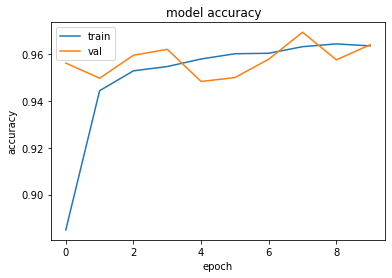

In [25]:
plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

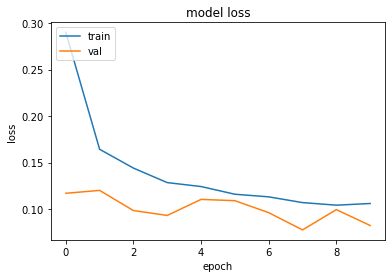

In [24]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("/home/furkan/Documents/ReducedData10Ep.hdf5")

In [12]:
test_idg = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_idg.flow_from_directory(
    test_path,
    batch_size = 16,
    shuffle = False,
    class_mode='categorical'
)
len(test_gen.filenames)

Found 8617 images belonging to 2 classes.


8617

In [13]:
test_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
test_labels = test_gen.classes


In [15]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [16]:
test_steps = (test_gen.n // test_gen.batch_size)+1

In [17]:
model.evaluate_generator(test_gen, verbose=1, steps=test_steps)

/home/furkan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


539/539 [==============================] - 354s 656ms/step - loss: 0.6325 - accuracy: 0.6995


[0.632516086101532, 0.6995474100112915]

In [18]:
predictions = model.predict_generator(test_gen, steps=test_steps+1, verbose=1)

/home/furkan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


540/540 [==============================] - 356s 658ms/step


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
predictions

In [20]:


cm = confusion_matrix(test_labels, predictions.argmax(axis=1))



Confusion matrix, without normalization
[[4556  581]
 [2008 1472]]


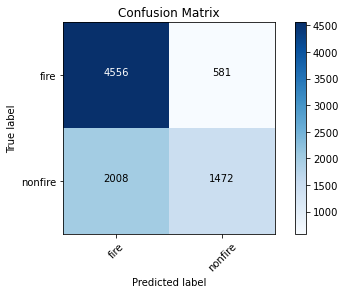

In [23]:
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')